# ECE 498 DS Mini Project 2 - Template

# schyu2, manukov2, jjchan3

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

### 1. With increased samples, biologists can apply the central limit theorum to the population mean of microbe abundance. This is required versus only taking few samples, because us a sample may happen to be an exteme under the population distribution, resulting in the analyzed and concluded population mean being very far from the truth.

In [2]:
import pandas as pd #importing pandas
RelativeAbundance_HE0Df = pd.read_csv("RelativeAbundance_HE0.csv") #importing the dataset
RelativeAbundance_HE1Df = pd.read_csv("RelativeAbundance_HE1.csv") #importing the dataset

In [3]:
# Getting the number of rows(microbes) and columns(1 + number of samples)
print(RelativeAbundance_HE0Df.shape[0])
print(RelativeAbundance_HE0Df.shape[1])

149
765


### 2. There are 764 samples analyzed. ( = ncolumns - 1 b/c one column is occupied by microbe names)

### 3. There are 149 microbes identified.

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization :

P(Quality, Contamination, Lab Time Before Processing, Collection Method, Storage Temp) 

= P(Quality | Contamination, Lab Time Before Processing, Collection Method, Storage Temp) * P(Contamination | Lab Time Before Processing, Collection Method, Storage Temp) * P(Lab Time Before Processing| Collection Method, Storage Temp) * P(Collection Method | Storage Temp) * P(Storage Temp)  

= P(Quality|Contamination, Lab Time Before Processing) P(Contamination | Collection Method, Storage Temp) * P(Lab Time Before Processing) * P(Collection Method) * P(Storage Temp)

### b. Parameters Required

Because the joint distribution can be written as: 
P(Quality|Contamination, Lab Time Before Processing) P(Contamination | Collection Method, Storage Temp) * P(Lab Time Before Processing) * P(Collection Method) * P(Storage Temp), where every variable is binomial, we will need 
4 + 4 + 1 + 1 + 1 = 11 parameters. 

### c. Constructing Probability Tables

In [4]:
QualityControlDf = pd.read_csv("QualityControl.csv")

In [5]:
QualityControlDf.head()

,strtmp,coll,labtime,cont,qual
0,cold,nurse,short,low,good
1,cold,nurse,short,low,good
2,cold,nurse,short,low,bad
3,cold,nurse,short,high,good
4,cold,nurse,short,low,good


In [6]:
def plabtime(labtime):
    return(len(QualityControlDf[QualityControlDf['labtime'] == labtime])/len(QualityControlDf))
P_LabTimeDf = pd.DataFrame()
P_LabTimeDf['LabTime'] = QualityControlDf['labtime'].unique()
P_LabTimeDf['P(LabTime)'] = P_LabTimeDf['LabTime'].apply(plabtime)
print(P_LabTimeDf)

def pcoll(coll):
    return(len(QualityControlDf[QualityControlDf['coll'] == coll])/len(QualityControlDf))
P_CollectionMethodDf = pd.DataFrame()
P_CollectionMethodDf['CollectionMethod'] = QualityControlDf['coll'].unique()
P_CollectionMethodDf['P(CollectionMethod)'] = P_CollectionMethodDf['CollectionMethod'].apply(pcoll)
print(P_CollectionMethodDf)

def pstoragetemp(strtmp):
    return(len(QualityControlDf[QualityControlDf['strtmp'] == strtmp])/len(QualityControlDf))
P_StorageTempDf = pd.DataFrame()
P_StorageTempDf['StorageTemp'] = QualityControlDf['strtmp'].unique()
P_StorageTempDf['P(StorageTemp)'] = P_StorageTempDf['StorageTemp'].apply(pstoragetemp)
print(P_StorageTempDf)

def pcontamination(cont, strtmp,coll):
    return(len(QualityControlDf[(QualityControlDf['cont'] == cont) & (QualityControlDf['strtmp'] == strtmp) & (QualityControlDf['coll'] == coll)])/len(QualityControlDf[(QualityControlDf['strtmp'] == strtmp) & (QualityControlDf['coll'] == coll)]))
combinations_for_cont = [('high','cold','nurse')
                ,('low','cold','nurse')
                ,('high', 'cool', 'nurse')
                ,('low', 'cool', 'nurse')
                ,('high','cold','patient')
                ,('low','cold','patient')
                ,('high', 'cool', 'patient')
                ,('low', 'cool', 'patient')]
P_ContaminationDf = pd.DataFrame(combinations_for_cont, columns=['Contamination', 'StorageTemp', 'CollectionMethod'])
P_ContaminationDf['P(Contamination|StorageTemp, CollectionMethod)'] = P_ContaminationDf.apply(lambda x: pcontamination(x.Contamination, x.StorageTemp, x.CollectionMethod), axis=1)
print(P_ContaminationDf)

def pquality(qual, cont,labtime):
    return(len(QualityControlDf[(QualityControlDf['qual'] == qual) & (QualityControlDf['cont'] == cont) & (QualityControlDf['labtime'] == labtime)])/len(QualityControlDf[(QualityControlDf['cont'] == cont) & (QualityControlDf['labtime'] == labtime)]))
combinations_for_qual = [('good','high','short')
                        ,('bad','high','short')
                        ,('good', 'low', 'short')
                        ,('bad', 'low', 'short')
                        ,('good','high','long')
                        ,('bad','high','long')
                        ,('good', 'low', 'long')
                        ,('bad', 'low', 'long')]
P_QualityDf = pd.DataFrame(combinations_for_qual, columns=['Quality', 'Contamination', 'LabTime'])
P_QualityDf['P(Quality|Contamination, LabTime)'] = P_QualityDf.apply(lambda x: pquality(x.Quality, x.Contamination, x.LabTime), axis=1)
print(P_QualityDf)


  LabTime  P(LabTime)
0   short      0.7956
1    long      0.2044
  CollectionMethod  P(CollectionMethod)
0            nurse               0.8976
1          patient               0.1024
  StorageTemp  P(StorageTemp)
0        cold          0.8982
1        cool          0.1018
  Contamination StorageTemp CollectionMethod  \
0          high        cold            nurse   
1           low        cold            nurse   
2          high        cool            nurse   
3           low        cool            nurse   
4          high        cold          patient   
5           low        cold          patient   
6          high        cool          patient   
7           low        cool          patient   

   P(Contamination|StorageTemp, CollectionMethod)  
0                                        0.043983  
1                                        0.956017  
2                                        0.088435  
3                                        0.911565  
4                              

### d. Final Probability Tables

In [7]:
# P(Qualtiy | Storage Temp , COllection Method, Labtime) =P (Qualtiy , Storage Temp , COllection Method, Labtime ) / P(Storage Temp , COllection Method, Labtime)


Combinations_final =  [('good','cold', 'nurse',   'short'),
                       ('bad', 'cold', 'nurse',   'short'),
                       ('good','cool', 'nurse',   'short'),
                       ('bad', 'cool', 'nurse',   'short'),
                       ('good','cold', 'patient', 'short'),
                       ('bad', 'cold', 'patient', 'short'),
                       ('good','cool', 'patient', 'short'),
                       ('bad', 'cool', 'patient', 'short'),
                       ('good','cold', 'nurse',   'long'),
                       ('bad', 'cold', 'nurse',   'long'),
                       ('good','cool', 'nurse',   'long'),
                       ('bad', 'cool', 'nurse',   'long'),
                       ('good','cold', 'patient', 'long'),
                       ('bad', 'cold', 'patient', 'long'),
                       ('good','cool', 'patient', 'long'),
                       ('bad', 'cool', 'patient', 'long')]
P_Final_Df = pd.DataFrame(Combinations_final, columns = ['Quality' , 'StorageTemp', 'CollectionMethod' , 'LabTime'])
def pfinal(qual, strtmp, coll, labtime):
    qualmask = QualityControlDf['qual'] == qual
    strtmpmask = QualityControlDf['strtmp'] == strtmp
    collmask = QualityControlDf['coll'] == coll
    labtimemask = QualityControlDf['labtime'] == labtime
    num = len(QualityControlDf[qualmask & strtmpmask & collmask & labtimemask])
    denom = len(QualityControlDf[strtmpmask & collmask & labtimemask])
    return(num/denom)
P_Final_Df['P(Quality|StorageTemp, CollectionMethod, LabTime)'] = P_Final_Df.apply(lambda x: pfinal(x.Quality, x.StorageTemp, x.CollectionMethod, x.LabTime), axis =1 )
print(P_Final_Df)

   Quality StorageTemp CollectionMethod LabTime  \
0     good        cold            nurse   short   
1      bad        cold            nurse   short   
2     good        cool            nurse   short   
3      bad        cool            nurse   short   
4     good        cold          patient   short   
5      bad        cold          patient   short   
6     good        cool          patient   short   
7      bad        cool          patient   short   
8     good        cold            nurse    long   
9      bad        cold            nurse    long   
10    good        cool            nurse    long   
11     bad        cool            nurse    long   
12    good        cold          patient    long   
13     bad        cold          patient    long   
14    good        cool          patient    long   
15     bad        cool          patient    long   

    P(Quality|StorageTemp, CollectionMethod, LabTime)  
0                                            0.955112  
1                   

### e. Cleaning the dataset

In [8]:
BayesInferenceHE0DF = pd.read_csv("BayesInferenceHE0.csv")
BayesInferenceHE1DF = pd.read_csv("BayesInferenceHE1.csv")

In [9]:
HE0_bad = []
for i in range(0,len(BayesInferenceHE0DF)):
    pgood = pfinal('good',BayesInferenceHE0DF['strtmp'][i],
                   BayesInferenceHE0DF['coll'][i],
                   BayesInferenceHE0DF['labtime'][i])
    pbad = pfinal('bad',BayesInferenceHE0DF['strtmp'][i],
                   BayesInferenceHE0DF['coll'][i],
                   BayesInferenceHE0DF['labtime'][i])
    if (pgood < pbad):
        HE0_bad.append(BayesInferenceHE0DF['SampleName'][i])

HE1_bad = []
for i in range(0,len(BayesInferenceHE1DF)):
    pgood = pfinal('good',BayesInferenceHE1DF['strtmp'][i],
                   BayesInferenceHE1DF['coll'][i],
                   BayesInferenceHE1DF['labtime'][i])
    pbad = pfinal('bad',BayesInferenceHE1DF['strtmp'][i],
                   BayesInferenceHE1DF['coll'][i],
                   BayesInferenceHE1DF['labtime'][i])
    if (pgood < pbad):
        HE1_bad.append(BayesInferenceHE1DF['SampleName'][i])

In [10]:
print(HE0_bad)
for i in HE0_bad:
    BayesInferenceHE0DF = BayesInferenceHE0DF[(BayesInferenceHE0DF['SampleName'] != i)]
    if (i in RelativeAbundance_HE0Df.columns):
        del RelativeAbundance_HE0Df[i]
print(HE1_bad)
for i in HE1_bad:
    BayesInferenceHE1DF = BayesInferenceHE1DF[(BayesInferenceHE1DF['SampleName'] != i)]
    if (i in RelativeAbundance_HE1Df.columns):
        del RelativeAbundance_HE1Df[i]

['HE0Sample_699', 'HE0Sample_700', 'HE0Sample_701', 'HE0Sample_702', 'HE0Sample_703', 'HE0Sample_704', 'HE0Sample_705', 'HE0Sample_706', 'HE0Sample_707', 'HE0Sample_708', 'HE0Sample_709', 'HE0Sample_710', 'HE0Sample_711', 'HE0Sample_712', 'HE0Sample_713', 'HE0Sample_714', 'HE0Sample_715', 'HE0Sample_716', 'HE0Sample_717', 'HE0Sample_718', 'HE0Sample_719', 'HE0Sample_720', 'HE0Sample_721', 'HE0Sample_722', 'HE0Sample_723', 'HE0Sample_724', 'HE0Sample_725', 'HE0Sample_726', 'HE0Sample_727', 'HE0Sample_728', 'HE0Sample_729', 'HE0Sample_730', 'HE0Sample_731', 'HE0Sample_732', 'HE0Sample_733', 'HE0Sample_734', 'HE0Sample_735', 'HE0Sample_736', 'HE0Sample_737', 'HE0Sample_738', 'HE0Sample_739', 'HE0Sample_740', 'HE0Sample_741', 'HE0Sample_742', 'HE0Sample_743', 'HE0Sample_744', 'HE0Sample_745', 'HE0Sample_746', 'HE0Sample_747', 'HE0Sample_748', 'HE0Sample_749', 'HE0Sample_750', 'HE0Sample_751', 'HE0Sample_752', 'HE0Sample_753', 'HE0Sample_754', 'HE0Sample_755', 'HE0Sample_756', 'HE0Sample_75

## 2. Data Standardization

### 1. Verify Relative Abundance

In [11]:
# This delta value is a placeholder in case it is required to have the column sum be within a delta value of 1.
delta = 10 ** -10

for i in RelativeAbundance_HE0Df.iloc[:, 1:]:
    col_sum = RelativeAbundance_HE0Df.loc[:][i].sum()
    
    # if the absolute difference between 1 and the column sum is greater than delta, discard the column
    if (abs(1 - col_sum) > delta):
        del RelativeAbundance_HE0Df[i]
        
display(RelativeAbundance_HE0Df)

for i in RelativeAbundance_HE1Df.iloc[:, 1:]:
    col_sum = RelativeAbundance_HE1Df.loc[:][i].sum()
    
    # if the absolute difference between 1 and the column sum is greater than delta, discard the column
    if (abs(1 - col_sum) > delta):
        del RelativeAbundance_HE1Df[i]
        
display(RelativeAbundance_HE1Df)

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_689,HE0Sample_690,HE0Sample_691,HE0Sample_692,HE0Sample_693,HE0Sample_694,HE0Sample_695,HE0Sample_696,HE0Sample_697,HE0Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004681,0.005588,0.004256,0.003755,0.004995,0.006198,0.006096,0.003961,0.003970,0.005229
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.007489,0.011874,0.011103,0.014661,0.009301,0.010331,0.012716,0.011195,0.011731,0.014642
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.005055,0.002095,0.005736,0.004291,0.006545,0.004132,0.004877,0.004823,0.001985,0.004532
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.004306,0.003318,0.004626,0.004112,0.004823,0.005447,0.004877,0.003961,0.003609,0.003486
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.005242,0.002445,0.005736,0.005006,0.004306,0.004884,0.002613,0.004650,0.005234,0.004183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Tenericutes_Mollicutes_Anaeroplasmatales_Anaer...,0.004792,0.003983,0.004976,0.004285,0.003985,0.003963,0.003429,0.005458,0.005154,...,0.003370,0.005762,0.003516,0.004291,0.005167,0.004508,0.002961,0.005512,0.003970,0.003486
145,Tenericutes_Mollicutes_Haloplasmatales_Halopla...,0.004976,0.004345,0.004792,0.007499,0.004332,0.003274,0.004286,0.004930,0.003951,...,0.004306,0.003143,0.003516,0.005364,0.003445,0.005447,0.004355,0.004306,0.005414,0.003660
146,Tenericutes_Mollicutes_Mycoplasmatales_Mycopla...,0.013638,0.010139,0.011611,0.010891,0.009184,0.009478,0.013544,0.014261,0.012541,...,0.014604,0.011524,0.013138,0.013231,0.008612,0.010706,0.010625,0.009645,0.012272,0.008192
147,Thermodesulfobacteria_Thermodesulfobacteria_Th...,0.003870,0.003802,0.004423,0.003571,0.004159,0.004825,0.004972,0.003345,0.004810,...,0.006366,0.004365,0.004626,0.004827,0.005856,0.003757,0.004180,0.002756,0.004512,0.004009


,Microbe Name,HE1Sample_0,HE1Sample_1,HE1Sample_2,HE1Sample_3,HE1Sample_4,HE1Sample_5,HE1Sample_6,HE1Sample_7,HE1Sample_8,...,HE1Sample_689,HE1Sample_690,HE1Sample_691,HE1Sample_692,HE1Sample_693,HE1Sample_694,HE1Sample_695,HE1Sample_696,HE1Sample_697,HE1Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004864,0.004041,0.005630,0.005046,0.005041,0.005278,0.004005,0.003700,0.004295,...,0.005573,0.004854,0.005412,0.004985,0.004070,0.003940,0.003880,0.004454,0.003743,0.005301
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.011985,0.012124,0.010732,0.012074,0.009001,0.012559,0.013234,0.011284,0.011391,...,0.010786,0.011963,0.011571,0.010657,0.013136,0.009381,0.012875,0.009280,0.010479,0.009322
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.005211,0.003866,0.004926,0.004505,0.005401,0.005461,0.005050,0.003330,0.003922,...,0.004494,0.004508,0.002613,0.005672,0.003330,0.005253,0.004409,0.005011,0.005801,0.005301
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003995,0.003866,0.004046,0.005406,0.003600,0.006189,0.003308,0.004255,0.004482,...,0.004494,0.005721,0.004479,0.002922,0.005365,0.004503,0.003527,0.005568,0.004304,0.006946
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.002953,0.003514,0.004574,0.005046,0.003420,0.004186,0.004701,0.004624,0.003361,...,0.002876,0.003467,0.004479,0.002922,0.003885,0.004690,0.004233,0.006496,0.003743,0.006215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Tenericutes_Mollicutes_Anaeroplasmatales_Anaer...,0.005211,0.004920,0.004750,0.004505,0.004320,0.004004,0.004701,0.005734,0.003922,...,0.004674,0.003988,0.005226,0.004641,0.005180,0.004878,0.004056,0.005197,0.005801,0.003838
145,Tenericutes_Mollicutes_Haloplasmatales_Halopla...,0.002953,0.004744,0.002463,0.005226,0.003960,0.004186,0.003657,0.004070,0.004482,...,0.003775,0.005028,0.002986,0.005156,0.005180,0.003752,0.005644,0.004640,0.005988,0.005483
146,Tenericutes_Mollicutes_Mycoplasmatales_Mycopla...,0.012507,0.009840,0.010204,0.010993,0.011161,0.009829,0.012711,0.012394,0.007656,...,0.011145,0.011096,0.009518,0.012204,0.013321,0.008068,0.014286,0.012992,0.010292,0.009687
147,Thermodesulfobacteria_Thermodesulfobacteria_Th...,0.005906,0.004217,0.005102,0.004505,0.003420,0.006189,0.004179,0.004070,0.004482,...,0.003236,0.004854,0.002240,0.003266,0.003885,0.004690,0.003880,0.004083,0.005052,0.005118


### 2. Discussion on Relative Abundance Data

A benefit of using relative abundance data is so that analysis is not skewed by the units of each sample. It's possible that the amounts of a particular microbe are very different between two samples while the relative abundances of that microbe is not that much different. The sample with a greater amount of the microbe may have greater effect in data analysis than the other sample which may not be ideal. 

A drawback of using relative abundance data is that you lose the units of each microbe in samples. If a condition occurs when a certain amount of microbe is present in a sample, it would not be able to detected since the data does not provide how much of a microbe is in each sample.

There is information loss during normalization. As stated earlier, you lose track how much of each microbe was found in each sample.

## 3. Visual Inspection

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

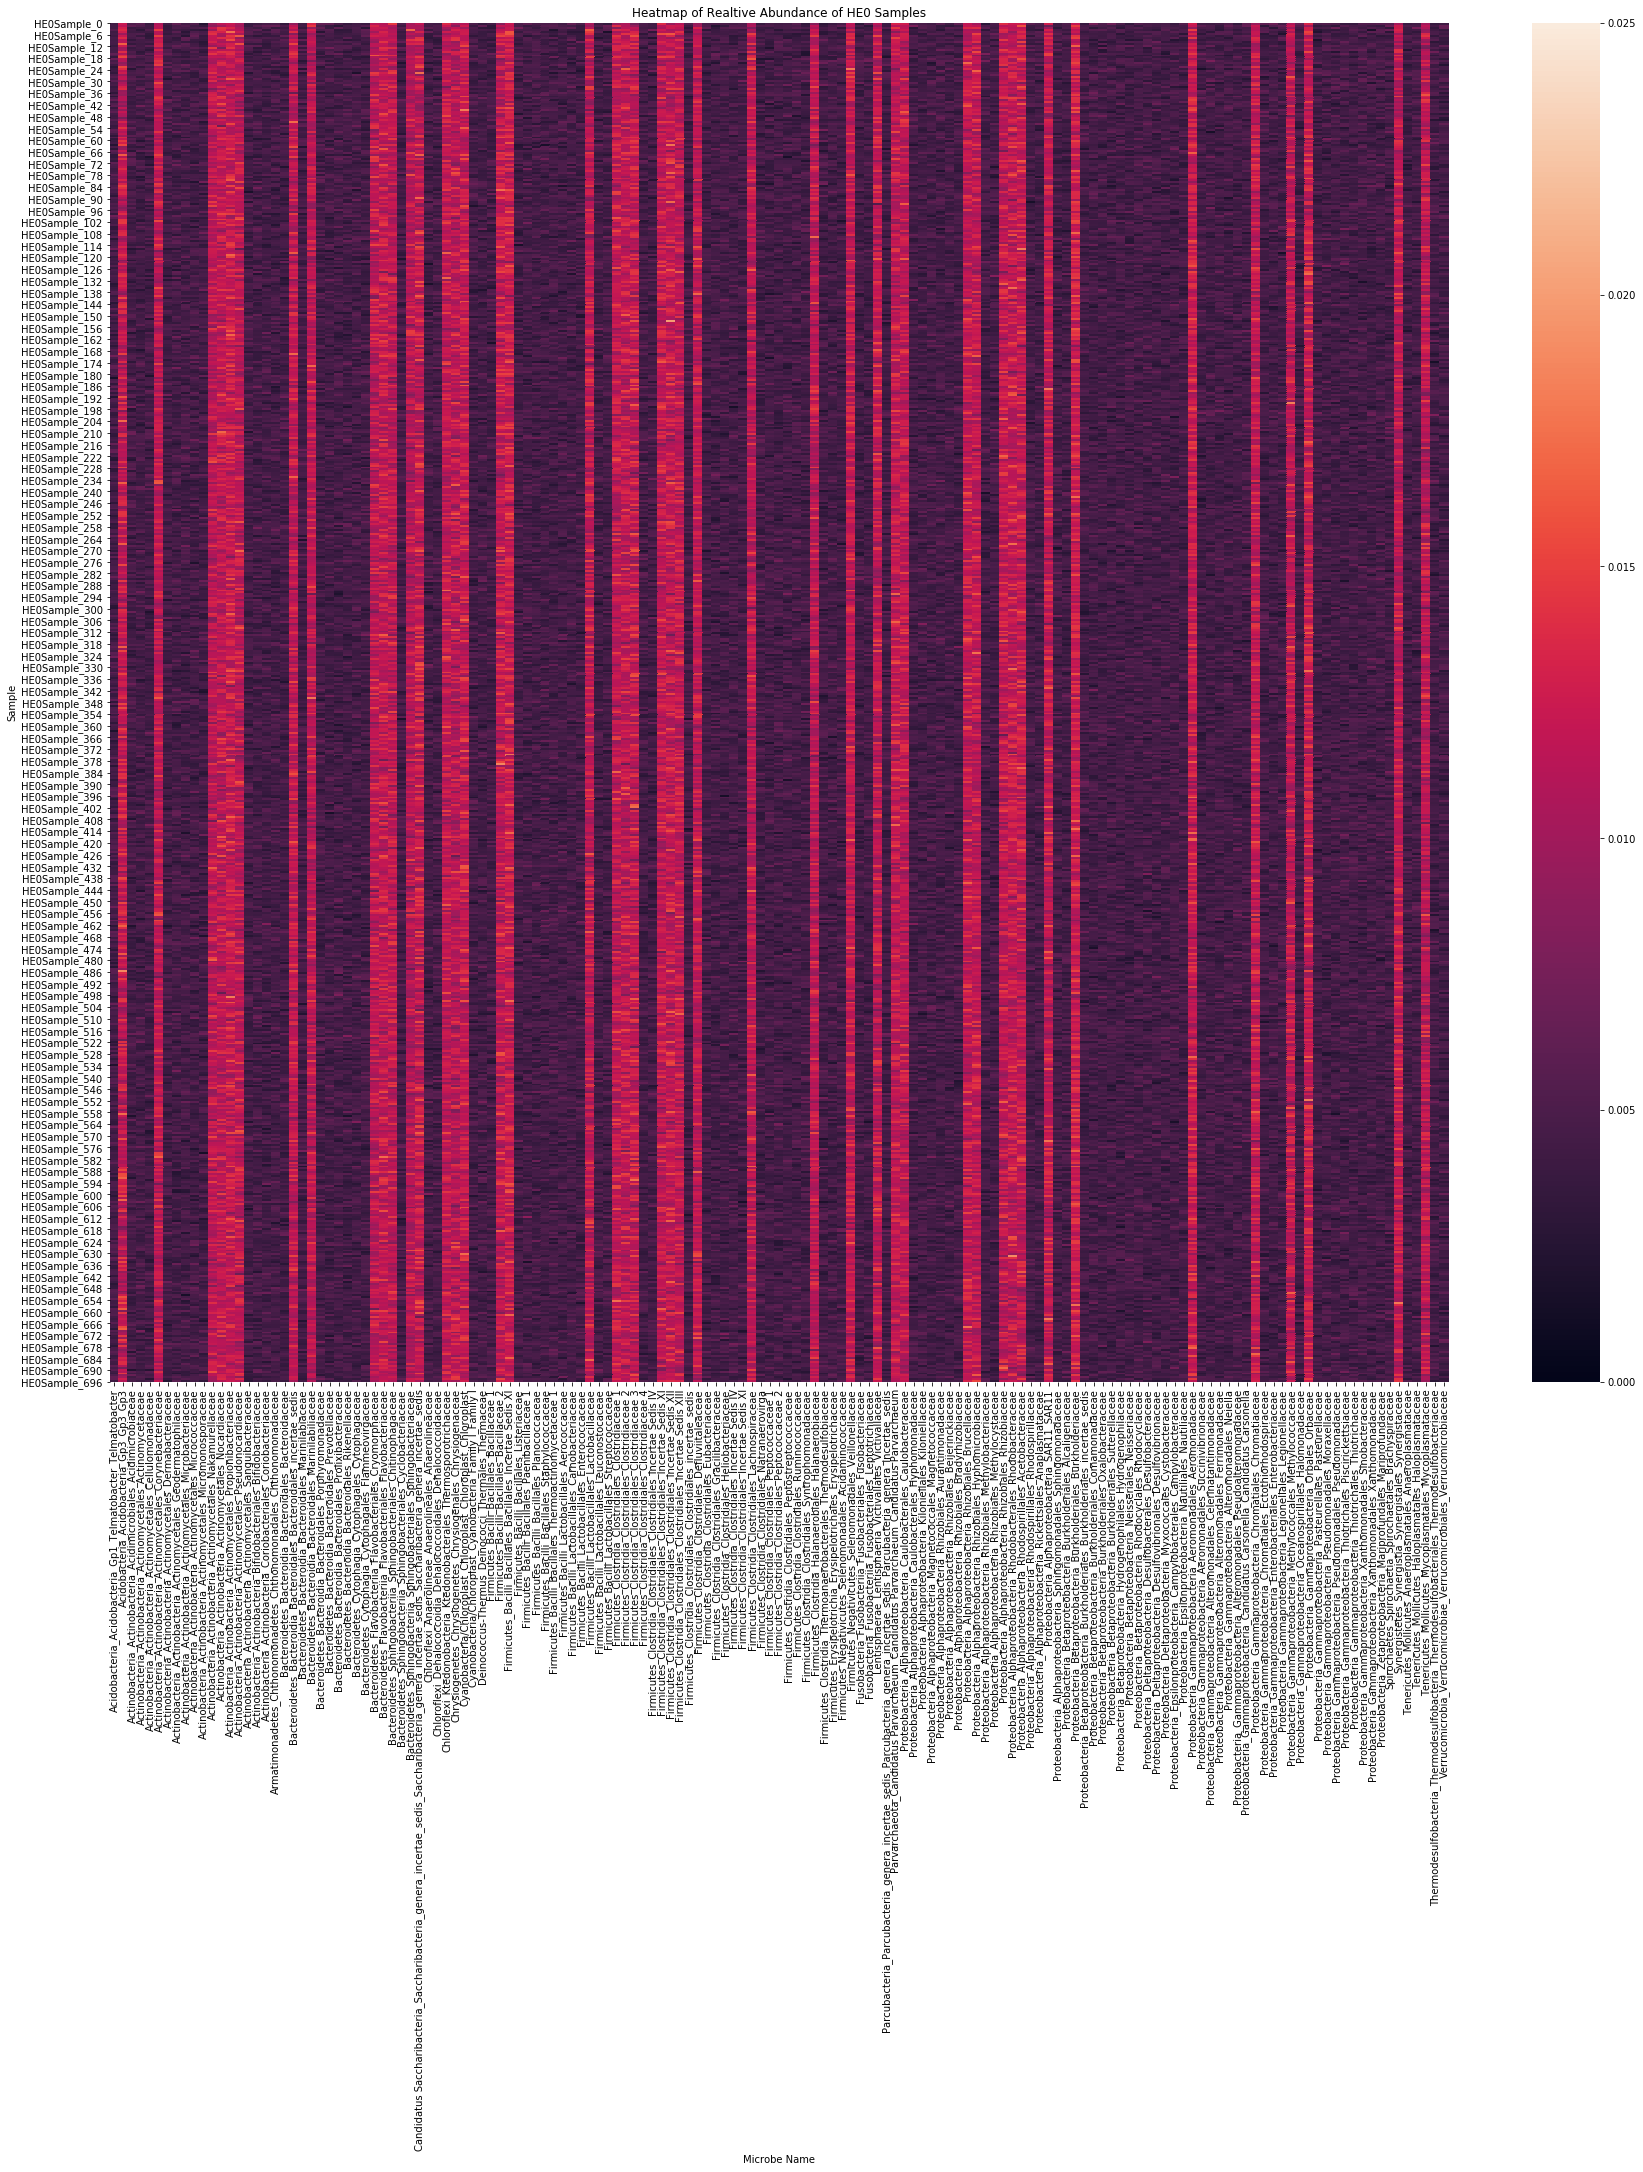

In [13]:
# Plot heatmap for HE0 samples

fig1, ax1 = plt.subplots(figsize = (30, 25))
sns.heatmap(RelativeAbundance_HE0Df.iloc[:, 1:].transpose(), vmin = 0, vmax = 0.025, xticklabels = RelativeAbundance_HE0Df["Microbe Name"], ax = ax1)
ax1.set_title("Heatmap of Realtive Abundance of HE0 Samples")
ax1.set_xlabel("Microbe Name")
ax1.set_ylabel("Sample")

# Save plot to image file
plt.savefig("RelativeAbundanceHE0_Heatmap.png")

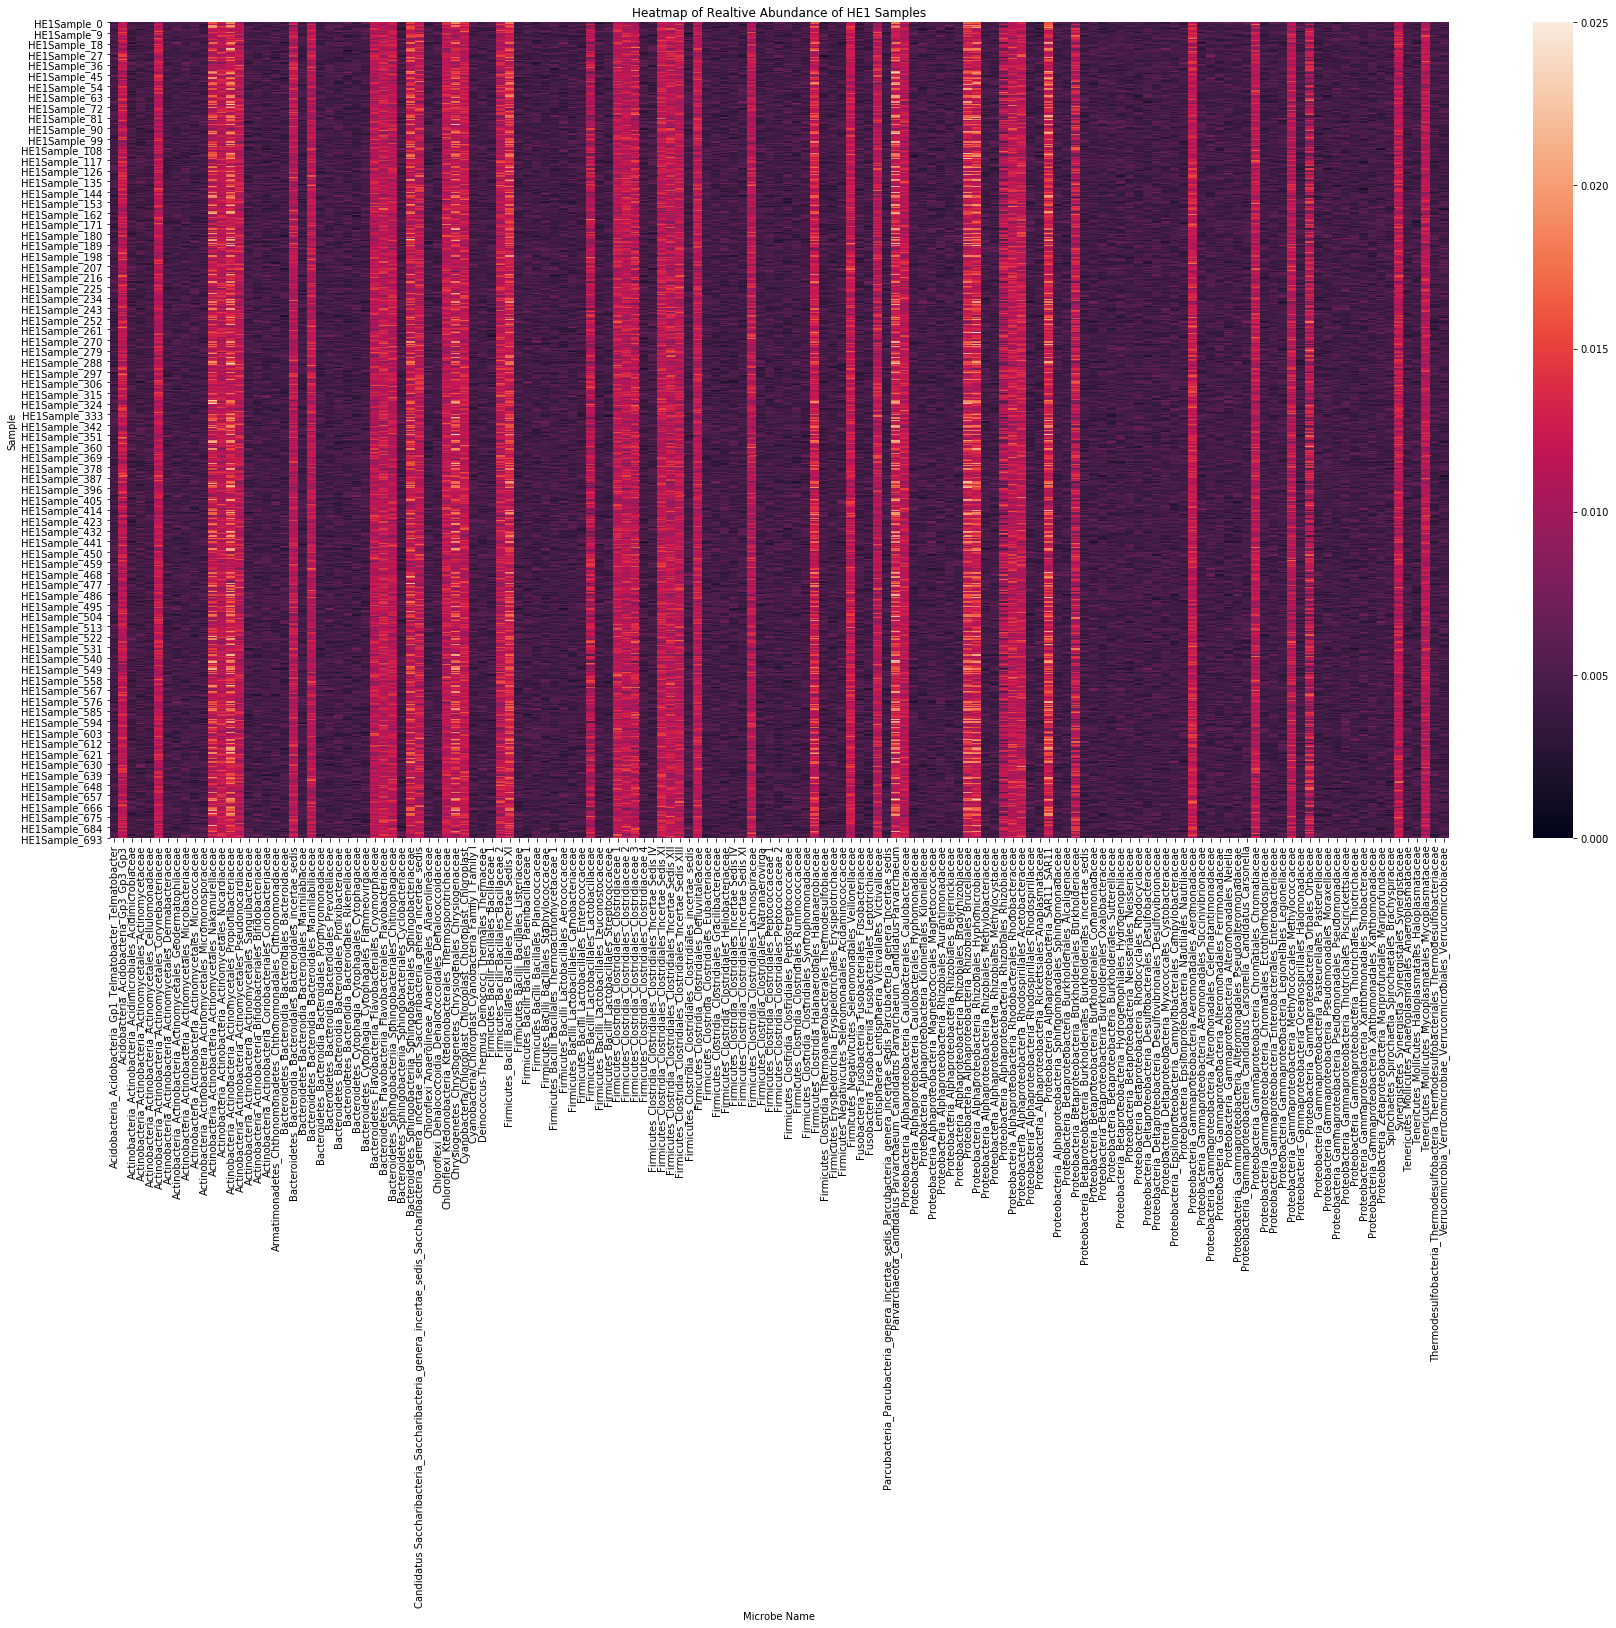

In [14]:
# Plot heatmap for HE1 samples

fig1, ax1 = plt.subplots(figsize = (30, 15))
sns.heatmap(RelativeAbundance_HE1Df.iloc[:, 1:].transpose(), vmin = 0, vmax = 0.025, xticklabels = RelativeAbundance_HE1Df["Microbe Name"], ax = ax1)
ax1.set_title("Heatmap of Realtive Abundance of HE1 Samples")
ax1.set_xlabel("Microbe Name")
ax1.set_ylabel("Sample")

# save plot to image file
plt.savefig("RelativeAbundanceHE1_Heatmap.png")

$\textbf{Observations}$

Across both the HE0 samples and the HE1 samples, there appears to be a set of microbes that have a higher relative abundance than the rest of the microbes within each sample. Between the HE0 and HE1 datatsets, microbes with lower relative abundances (the microbes with darker squares overall) don't seem to have very different values for relative abundance. The microbes with higher relative abundances (the microbes with lighter squares overall) within the HE1 dataset have certain microbes in particular samples that have much higher relative abundance values than their counterparts in the HE0 dataset, as indicated by the squares with much lighter colors present in the HE1 dataset. 

$\textbf{Benefits and Drawbacks of Using Heatmaps}$

The heatmaps are good at highlighting the differences between relative abundances; these differences are easy to visualize between light and dark colored cells. As such, it is easy to identify which microbes have samples that have relatively high relative abundances. Examining the precise differences between samples is difficult; it is hard to determine the precise value of each cell just by looking at the figure.

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [15]:
from scipy import stats

In [91]:
len(RelativeAbundance_HE0Df)

149

In [101]:
RelativeAbundance_HE0Df["Microbe Name"][0]

'Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter'

In [152]:
p_values = [] #creating array for all P-values
microbe_names = []

for i in range(RelativeAbundance_HE0Df.shape[0]):
    p = stats.ks_2samp(RelativeAbundance_HE0Df.iloc[i, 1:], RelativeAbundance_HE1Df.iloc[i, 1:])
    p_values.append(p[1])
    microbe_names.append(RelativeAbundance_HE0Df["Microbe Name"][i])

p_values = pd.DataFrame(p_values)

In [153]:
p_values

,0
0,0.180486
1,0.002664
2,0.110367
3,0.540633
4,0.937428
...,...
144,0.125354
145,0.064432
146,0.022486
147,0.763006


### b. Null Hypothesis of the KS Test in our Context

**NULL**: There is no statistically significant difference in abundance of a microbe between samples with Hepatic Encephalopathy and those without Hepatic Encephalopathy  

For example, the microbe Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter has a P-value of 0.18. Assuming our cut off to be .05, we would not have enough evidence to reject the null and thus conclude that there is no statistically significant difference in abundance of Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter in patients with HE and in patients without HE

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [156]:
p_values[0]

0      0.180486
1      0.002664
2      0.110367
3      0.540633
4      0.937428
         ...   
144    0.125354
145    0.064432
146    0.022486
147    0.763006
148    0.804847
Name: 0, Length: 149, dtype: float64

In [180]:
alpha1 = 0
alpha05 = 0
alpha01 = 0
alpha005 = 0
alpha001 = 0

for i in p_values[0]:
    if i < .1:
        alpha1 += 1
    if i < .05:
        alpha05 += 1
    if i < .01:
        alpha01 += 1
    if i < .005:
        alpha005 += 1
    if i < .001:
        alpha001 += 1
        
        
alpha = [.1, .05, .01, .005, .001]
counts = [alpha1, alpha05, alpha01, alpha005, alpha001]

In [185]:
table = pd.DataFrame(
    {'Alpha': alpha,
     'Counts': counts
    })

In [186]:
table

,Alpha,Counts
0,0.100,50
1,0.050,37
2,0.010,27
3,0.005,26
4,0.001,21


## 2. Multiple Testing

### a. P-value

### b. P-value Distribution

### c. Expected Number of Significant p-values

### d. Q-Q plot of p-values

#### i. 

#### ii. 

#### iii. 

#### iv. 

#### v. 

#### vi. 

### e. Follow-up Questions

#### i. 

#### ii. 

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA


### b. Ordering Components

### c. Scatter Plot of Microbe Abundance

## 2. t-SNE

### a. Performing t-SNE

### b. Comparing with PCA

## 3. Clustering

### a. K-Means

### b. GMM

### c. Single and Complete Linkage Hierarchical

### d. Single vs Complete Link Hierarchical Clustering

### e. Comparing Clustering Techniques

### f. What do Clusters Represent

### g. Deciding on Number of Clusters

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

### c. Identify Microbes with Significantly Altered Relative Abundance

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

### b. Biological Relations